## base_net

- Conv1 (3, 300, 300) - (64, 150, 150)
    - (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (1): ReLU(inplace)
    - (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (3): ReLU(inplace)
    - (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
- Conv2 (64, 150, 150) - (128, 75, 75)
    - (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (6): ReLU(inplace)
    - (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (8): ReLU(inplace)
    - (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
- Conv3 (128, 75, 75) - (256, 38, 38) 
    - (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (11): ReLU(inplace)
    - (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (13): ReLU(inplace)
    - (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (15): ReLU(inplace)
    - (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
- Conv4 (256, 38, 38) - (512, 19, 19)
    - (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (18): ReLU(inplace)
    - (19): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (20): ReLU(inplace)
    - (21): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (22): ReLU(inplace) ***(512, 38,38)
    - (23): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
- Conv5 (512, 19, 19) - (512, 19, 19)
    - (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (25): ReLU(inplace)
    - (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (27): ReLU(inplace)
    - (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    - (29): ReLU(inplace)
    - (30): MaxPool2d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
- Conv6 (512, 19, 19)- (1024, 19, 19)
    - (31): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(6, 6), dilation=(6, 6))
    - (32): ReLU(inplace)
- Conv7 (1024, 19, 19) - (1024, 19, 19)
    - (33): Conv2d(1024, 1024, kernel_size=(1, 1), stride=(1, 1))
    - (34): ReLU(inplace) ***(1024, 19, 19)

## extras
- Conv8 (1024 19, 19) - (512, 10, 10) 
  - (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
  - (1): ReLU()
  - (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  - (3): ReLU() *** (512, 10, 10)
- Conv9 (512, 10, 10) - (256, 5, 5)
  - (0): Conv2d(512, 128, kernel_size=(1, 1), stride=(1, 1))
  - (1): ReLU()
  - (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  - (3): ReLU() *** (256, 5, 5)
- Conv10 (256, 5, 5) - (256, 3, 3)
  - (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  - (1): ReLU()
  - (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  - (3): ReLU() *** (256, 3, 3)
- Conv11 (256, 3, 3) - (256, 1, 1)
  - (0): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  - (1): ReLU()
  - (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  - (3): ReLU() *** (256, 1, 1)

In [8]:
import numpy as np
import torch
import os, sys
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("../")
from collections import OrderedDict

%load_ext autoreload
%autoreload 2

import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from vision.ssd.ssd import MatchPrior
from vision.utils.box_utils import (iou_of)

from vision.datasets.voc_dataset import VOCDataset
from vision.ssd.vgg_ssd import create_vgg_ssd
from vision.ssd.resnet50_ssd import create_resnet50_ssd, create_resnet50_ssd_v2, create_resnet50_ssd_predictor, convert_key_v2, modifie_weight
from vision.ssd.config.vgg_ssd_config import Config
from utils import *

anchors = [1,1,1]

# rectangles = [[2],[2,3],[2,3],[2,3],[2],[2]]
rectangles = [[2,3],[2,3],[2,3],[2,3],[2],[2]]

num_anchors = [6,6,6,6,4,4]
pretrained = "../models/vgg16_reducedfc.pth"

### ---- configuration

vgg_config=[64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'C', 512, 512, 512, 'M', 512, 512, 512]

# fral pool + (conv + Relu)
# vgg_config=[64, 64, "F11", 64, "F12", 128, 128, "F21", 128, "F22", 256, 256, 256, "F31", 256, "F32", 512, 512, 512, "F41", 512, "F42", 512, 512, 512]

# frac pool w/o (conv + relu)
# vgg_config=[64, 64, "F11", "F12", 128, 128, "F21", "F22", 256, 256, 256, "F31", "F32", 512, 512, 512, "F41", "F42", 512, 512, 512]

### ---- 

# create_net = create_vgg_ssd
create_net = create_resnet50_ssd
config = Config(anchors=anchors, rectangles=rectangles, num_anchors=num_anchors, vgg_config=vgg_config, pretrained=pretrained) # --- custom

net = create_net(21, config, is_test=True)

pretrained_dict = torch.load("../models/resnet50_ssd_voc_79.7.pth")
net_dict = net.state_dict() # base_net, num_batch...
pretrained_dict = convert_key_v2(pretrained_dict)
# # 1. fliter \ netにないkeyは消す
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}
# # 2. overwrite
net_dict.update(pretrained_dict)
# # 3. load
net.load_state_dict(net_dict)

ImportError: cannot import name 'convert_key_v2'

### load model weight / remove not matching key-weight


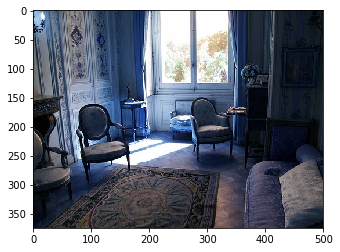

In [7]:
plt.imshow(cv2.imread("/home/yhosoya/img_data/VOCdevkit/VOC2007/JPEGImages/000196.jpg"))

In [10]:
dets_resnet = detection(scores.view(-1, 21).data, boxes.data, config.priors.view(1,11620,4).data)

torch.Size([11620, 4])
[0.1, 0.2]
torch.Size([11620, 4])
False
torch.Size([4, 4]) torch.Size([4])
torch.Size([2, 4]) torch.Size([2])
torch.Size([10, 4]) torch.Size([10])
torch.Size([48, 4]) torch.Size([48])
torch.Size([2, 4]) torch.Size([2])
torch.Size([3, 4]) torch.Size([3])
torch.Size([4545, 4]) torch.Size([4545])
torch.Size([141, 4]) torch.Size([141])
torch.Size([6, 4]) torch.Size([6])
torch.Size([81, 4]) torch.Size([81])
torch.Size([795, 4]) torch.Size([795])
torch.Size([507, 4]) torch.Size([507])
torch.Size([9, 4]) torch.Size([9])
torch.Size([55, 4]) torch.Size([55])


In [23]:
import torch
weight = torch.load("../models/anchor023/vgg16-ssd-Epoch-199-Loss-2.796176362806751.pth")

In [32]:
weight["classification_headers..weight"].shape

torch.Size([63, 256, 3, 3])

In [9]:

def nms(boxes, scores, overlap=0.5, top_k=200):
    """Apply non-maximum suppression at test time to avoid detecting too many
    overlapping bounding boxes for a given object.
    Args:
        boxes: (tensor) The location preds for the img, Shape: [num_priors,4].
        scores: (tensor) The class predscores for the img, Shape:[num_priors].
        overlap: (float) The overlap thresh for suppressing unnecessary boxes.
        top_k: (int) The Maximum number of box preds to consider.
    Return:
        The indices of the kept boxes with respect to num_priors.
    """

    keep = torch.Tensor(scores.size(0)).fill_(0).long()
    if boxes.numel() == 0:
        return keep
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]
    area = torch.mul(x2 - x1, y2 - y1)
    v, idx = scores.sort(0)  # sort in ascending order
    # I = I[v >= 0.01]
    idx = idx[-top_k:]  # indices of the top-k largest vals
    xx1 = boxes.new()
    yy1 = boxes.new()
    xx2 = boxes.new()
    yy2 = boxes.new()
    w = boxes.new()
    h = boxes.new()

    # keep = torch.Tensor()
    count = 0
    while idx.numel() > 0:
        i = idx[-1]  # index of current largest val
        # keep.append(i)
        keep[count] = i
        count += 1
        if idx.size(0) == 1:
            break
        idx = idx[:-1]  # remove kept element from view
        # load bboxes of next highest vals
        torch.index_select(x1, 0, idx, out=xx1)
        torch.index_select(y1, 0, idx, out=yy1)
        torch.index_select(x2, 0, idx, out=xx2)
        torch.index_select(y2, 0, idx, out=yy2)
        # store element-wise max with next highest score
        xx1 = torch.clamp(xx1, min=x1[i])
        yy1 = torch.clamp(yy1, min=y1[i])
        xx2 = torch.clamp(xx2, max=x2[i])
        yy2 = torch.clamp(yy2, max=y2[i])
        w.resize_as_(xx2)
        h.resize_as_(yy2)
        w = xx2 - xx1
        h = yy2 - yy1
        # check sizes of xx1 and xx2.. after each iteration
        w = torch.clamp(w, min=0.0)
        h = torch.clamp(h, min=0.0)
        inter = w*h
        # IoU = i / (area(a) + area(b) - i)
        rem_areas = torch.index_select(area, 0, idx)  # load remaining areas)
        union = (rem_areas - inter) + area[i]
        IoU = inter/union  # store result in iou
        # keep only elements with an IoU <= overlap
        idx = idx[IoU.le(overlap)]
    return keep, count


def decode(loc, priors, variances):
    print(priors.shape)
    print(variances)
    print(loc.shape)
    print(loc.is_cuda)
    """Decode locations from predictions using priors to undo
    the encoding we did for offset regression at train time.
    Args:
        loc (tensor): location predictions for loc layers,
            Shape: [num_priors,4]
        priors (tensor): Prior boxes in center-offset form.
            Shape: [num_priors,4].
        variances: (list[float]) Variances of priorboxes
    Return:
        decoded bounding box predictions
    """
    boxes = torch.cat((
        priors[:, :2] + loc[:, :2] * variances[0] * priors[:, 2:],
        priors[:, 2:] * torch.exp(loc[:, 2:] * variances[1])), 1)
    boxes[:, :2] -= boxes[:, 2:] / 2
    boxes[:, 2:] += boxes[:, :2]
    return boxes


def detection(scores, boxes, prior_data):
        """
        Args:
            loc_data: (tensor) Loc preds from loc layers
                Shape: [batch,num_priors*4]
            conf_data: (tensor) Shape: Conf preds from conf layers
                Shape: [batch*num_priors,num_classes]
            prior_data: (tensor) Prior boxes and variances from priorbox layers
                Shape: [1,num_priors,4]
        """
        loc_data = boxes.data.cpu()
        conf_data = scores.data.cpu()
        
        num = loc_data.size(0)  # batch size
        num_priors = prior_data.size(0)
        #self.output.zero_()
        if num == 1:
            # size batch x num_classes x num_priors
            conf_preds = conf_data.t().contiguous().unsqueeze(0)
        else:
            conf_preds = conf_data.view(num, num_priors,
                                        21).transpose(2, 1)
        output = torch.zeros(num, 21, 200, 5)

        gpunms_time = 0
        scores_time=0
        box_time=0
        cpu_tims=0
        sort_time=0
        decode_time=0
        nms_thresh = 0.5
        top_k = 200
        variance = [0.1, 0.2]
        # Decode predictions into bboxes.
        for i in range(num):
            decoded_boxes = decode(loc_data[i], prior_data[0], variance)
            # For each class, perform nms
            conf_scores = conf_preds[i].clone()
            num_det = 0
            for cl in range(1, 21):
                c_mask = conf_scores[cl].gt(0.01).nonzero().view(-1) # threshold
                if c_mask.dim() == 0:
                    continue
                scores = conf_scores[cl][c_mask]
                if scores.dim() == 0:
                    continue
                # l_mask = c_mask.unsqueeze(1).expand_as(decoded_boxes)
                # boxes = decoded_boxes[l_mask].view(-1, 4)
                boxes = decoded_boxes[c_mask, :]
                if boxes.shape[0] == 0:
                    continue
                print(boxes.shape, scores.shape)
                ids, count = nms(boxes, scores, nms_thresh, top_k)
                output[i, cl, :count] = \
                    torch.cat((scores[ids[:count]].unsqueeze(1),
                               boxes[ids[:count]]), 1)
        return output

In [3]:
def modifie_weight(net, pretrained_path):
    pretrained_dict = torch.load(pretrained_path)
    net_dict = net.state_dict() # base_net, num_batch...
    pretrained_dict = convert_key(pretrained_dict)

    # # 1. fliter \ netにないkeyは消す
    pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}
    # # 2. overwrite
    net_dict.update(pretrained_dict)
    # # 3. load
    net.load_state_dict(net_dict)
    
    
def convert_key(pretrained_dict):
    new_pretrained_dict = OrderedDict()
    extras_map = {"0": "0.0", "1": "0.1", "2": "1.0", "3": "1.1", "4": "2.0",  "5": "2.1", "6": "3.0", "7": "3.1"}
    for i in pretrained_dict.keys():
        # base -> base_net
        if i.startswith("base"):
            key = i.replace("base", "base_net")
            new_pretrained_dict[key] = pretrained_dict[i]
        # loc -> regression_headers
        elif i.startswith("loc"):
            key = i.replace("loc", "regression_headers")
            new_pretrained_dict[key] = pretrained_dict[i]
        # conf -> classification_headers
        elif i.startswith("conf"):
            key = i.replace("conf", "classification_headers")
            new_pretrained_dict[key] = pretrained_dict[i]
        # e.g. 0 -> 0.0 / 1 -> 0.1 ...
        elif i.startswith("extras"):
            key = i.replace(i.split(".")[1], extras_map[i.split(".")[1]])
            new_pretrained_dict[key] = pretrained_dict[i]
        else:
            new_pretrained_dict[i] = pretrained_dict[i]
    return new_pretrained_dict


In [4]:

pretrained_path = "../models/resnet50_ssd_voc_79.7.pth"
pretrained_dict = torch.load(pretrained_path)
net_dict = net.state_dict() # base_net, num_batch...
pretrained_dict = convert_key(pretrained_dict)

# # 1. fliter \ netにないkeyは消す
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in net_dict}
# # 2. overwrite
net_dict.update(pretrained_dict)
# # 3. load
net.load_state_dict(net_dict)

---
### find fragment result

In [153]:
import json
import numpy as np
import os, sys

def count_miss_and_fragment(json_object):
    count = 0
    miss = 0
    for key in json_object.keys():
        objects = sorted([ x for x in json_object[key].keys() if x.startswith("obj") ])
        for obj in objects:
            count += json_object[key][obj]["num_flicker"]
            miss += sum(json_object[key][obj]["miss"])
    print("count: {}".format(count))
    print("miss: {}".format(miss))

    

def matching_simple(json_object_basic, json_object_sigmoid):
    improved_mmd_dict = {}
    new_mmd_dict = {}
    stay_mmd_dict = {}
    stable_dict = {}
    
    improved_mmd = 0
    new_mmd = 0
    stay_mmd = 0
    stable = 0
    all_keys = json_object_basic.keys()
    for key in all_keys:
        improved_mmd_dict[key] = dict()
        new_mmd_dict[key] = dict()
        stay_mmd_dict[key] = dict()
        stable_dict[key] = dict()
        objects = sorted([ x for x in json_object_basic[key].keys() if x.startswith("obj") ])
        for obj in objects:
            improved_mmd_dict[key][obj] = list()
            new_mmd_dict[key][obj] = list()
            stay_mmd_dict[key][obj] = list()
            stable_dict[key][obj] = list()
            basic_miss = np.array(json_object_basic[key][obj]["miss"])
            sigmoid_miss = np.array(json_object_sigmoid[key][obj]["miss"])
            basic_mmd = np.array(json_object_basic[key][obj]["flicker_indicies"])
            sigmoid_mmd = np.array(json_object_sigmoid[key][obj]["flicker_indicies"])
            for frame in range(len(basic_miss)):
                
                # mmdが改善している（１→０）
                if basic_miss[frame] == 1 and sigmoid_miss[frame] == 0:
                    improved_mmd += 1
                    improved_mmd_dict[key][obj].append(frame)
                        
                # mmdが新たに生じている（０→１）
                elif basic_miss[frame] == 0 and sigmoid_miss[frame] == 1:  
                    new_mmd += 1
                    new_mmd_dict[key][obj].append(frame)
                    
                # mmdがそのまま，改善されない（１→１）
                elif basic_miss[frame] == 1 and sigmoid_miss[frame] == 1:
                    stay_mmd += 1
                    stay_mmd_dict[key][obj].append(frame)
                # どちらでも正しく検出（０→０）
                else:
                    stable += 1
                    stable_dict[key][obj].append(frame)
                    
    return (improved_mmd, new_mmd, stay_mmd, stable,
            (improved_mmd_dict, new_mmd_dict, stay_mmd_dict, stable_dict))
    
    

def matching(json_object_basic, json_object_sigmoid):
    improved_mmd_sig_is_miss_dict = {}
    improved_mmd_sig_is_correct_dict = {}
    new_mmd_base_is_miss_dict = {}
    new_mmd_base_is_correct_dict = {}
    stay_mmd_dict = {}
    stable_dict = {}
    
    improved_mmd_sig_is_miss = 0
    improved_mmd_sig_is_correct = 0
    new_mmd_base_is_miss = 0
    new_mmd_base_is_correct = 0
    stay_mmd = 0
    stable = 0
    all_keys = json_object_basic.keys()
    for key in all_keys:
        improved_mmd_sig_is_miss_dict[key] = dict()
        improved_mmd_sig_is_correct_dict[key] = dict()
        new_mmd_base_is_miss_dict[key] = dict()
        new_mmd_base_is_correct_dict[key] = dict()
        stay_mmd_dict[key] = dict()
        stable_dict[key] = dict()
        objects = sorted([ x for x in json_object_basic[key].keys() if x.startswith("obj") ])
        for obj in objects:
            improved_mmd_sig_is_miss_dict[key][obj] = list()
            improved_mmd_sig_is_correct_dict[key][obj] = list()
            new_mmd_base_is_miss_dict[key][obj] = list()
            new_mmd_base_is_correct_dict[key][obj] = list()
            stay_mmd_dict[key][obj] = list()
            stable_dict[key][obj] = list()
            basic_miss = np.array(json_object_basic[key][obj]["miss"])
            sigmoid_miss = np.array(json_object_sigmoid[key][obj]["miss"])
            basic_mmd = np.array(json_object_basic[key][obj]["flicker_indicies"])
            sigmoid_mmd = np.array(json_object_sigmoid[key][obj]["flicker_indicies"])
            for frame in range(len(basic_miss)):
                
                # mmdが改善している（１→０）
                if basic_mmd[frame] == 1 and sigmoid_mmd[frame] == 0:
                    if sigmoid_miss[frame] == 1: # 改善後にmissしているなら意味ない
                        improved_mmd_sig_is_miss += 1
                        improved_mmd_sig_is_miss_dict[key][obj].append(frame)
                    else:
                        improved_mmd_sig_is_correct += 1
                        improved_mmd_sig_is_correct_dict[key][obj].append(frame)
                        
                # mmdが新たに生じている（０→１）
                elif basic_mmd[frame] == 0 and sigmoid_mmd[frame] == 1:  
                    # その内，元が111で改善後が010になっていることでmmdと判定されているもの
                    if basic_miss[frame] == 1: # 元のフレームがそもそもmissしている場合
                        new_mmd_base_is_miss += 1
                        new_mmd_base_is_miss_dict[key][obj].append(frame)
                    else:
                        new_mmd_base_is_correct += 1
                        new_mmd_base_is_correct_dict[key][obj].append(frame)
                    
                # mmdがそのまま，改善されない（１→１）
                elif basic_mmd[frame] == 1 and sigmoid_mmd[frame] == 1:
                    stay_mmd += 1
                    stay_mmd_dict[key][obj].append(frame)
                # どちらでも正しく検出（０→０）
                else:
                    stable += 1
                    stable_dict[key][obj].append(frame)
                    
    return (improved_mmd_sig_is_miss, improved_mmd_sig_is_correct,
            new_mmd_base_is_miss, new_mmd_base_is_correct, 
            stay_mmd, stable,
            (improved_mmd_sig_is_miss_dict, improved_mmd_sig_is_correct_dict, new_mmd_base_is_miss_dict, new_mmd_base_is_correct_dict, stay_mmd_dict, stable_dict))


In [173]:
# SSD-VGG16
with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object_basic = json.load(f)
with open("../detect_result/find_fragment/vgg16_sigmoid_thresh_multilabel_thresh02/sw/0406/multilabel_fragment.json", "r") as f:
    json_object_sigmoid = json.load(f)
    
improved_mmd_sig_is_miss, improved_mmd_sig_is_correct, new_mmd_base_is_miss, new_mmd_base_is_correct, stay_mmd, stable, dicts = matching(json_object_basic, json_object_sigmoid)
print("improved_mmd(10): sig_is_miss/sig_is_correct  {}/{}".format(improved_mmd_sig_is_miss, improved_mmd_sig_is_correct))
print("new_mmd(01): base_is_miss/base_is_correct {}/{}".format(new_mmd_base_is_miss, new_mmd_base_is_correct))
print("stay_mmd(11): {}".format(stay_mmd))
print("stable(00): {}".format(stable))


improved_mmd(10): sig_is_miss/sig_is_correct  91/235
new_mmd(01): base_is_miss/base_is_correct 145/31
stay_mmd(11): 45
stable(00): 7593


In [174]:
# M2Det-VGG16
with open("../../M2Det/detect_result/find_fragment/ft_alllayer/basic/multilabel_fragment.json", "r") as f:
    json_object_basic = json.load(f)
with open("../../M2Det/detect_result/find_fragment/ft_alllayer/sigmoid/multilabel_fragment.json", "r") as f:
    json_object_sigmoid = json.load(f)
    
improved_mmd_sig_is_miss, improved_mmd_sig_is_correct, new_mmd_base_is_miss, new_mmd_base_is_correct, stay_mmd, stable, dicts = matching(json_object_basic, json_object_sigmoid)
print("improved_mmd(10): sig_is_miss/sig_is_correct  {}/{}".format(improved_mmd_sig_is_miss, improved_mmd_sig_is_correct))
print("new_mmd(01): base_is_miss/base_is_correct {}/{}".format(new_mmd_base_is_miss, new_mmd_base_is_correct))
print("stay_mmd(11): {}".format(stay_mmd))
print("stable(00): {}".format(stable))


improved_mmd(10): sig_is_miss/sig_is_correct  52/197
new_mmd(01): base_is_miss/base_is_correct 116/35
stay_mmd(11): 57
stable(00): 7683


In [175]:
# IOU 05 vs 04
with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object_basic = json.load(f)
with open("../detect_result/find_fragment/compare/vgg16_IoU_04/multilabel_fragment.json", "r") as f:
    json_object_sigmoid = json.load(f)
    
improved_mmd_sig_is_miss, improved_mmd_sig_is_correct, new_mmd_base_is_miss, new_mmd_base_is_correct, stay_mmd, stable, dicts = matching(json_object_basic, json_object_sigmoid)
print("improved_mmd(10): sig_is_miss/sig_is_correct  {}/{}".format(improved_mmd_sig_is_miss, improved_mmd_sig_is_correct))
print("new_mmd(01): base_is_miss/base_is_correct {}/{}".format(new_mmd_base_is_miss, new_mmd_base_is_correct))
print("stay_mmd(11): {}".format(stay_mmd))
print("stable(00): {}".format(stable))


improved_mmd(10): sig_is_miss/sig_is_correct  109/204
new_mmd(01): base_is_miss/base_is_correct 194/57
stay_mmd(11): 58
stable(00): 7518


In [157]:
# SSD-VGG16
with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object_basic = json.load(f)
with open("../detect_result/find_fragment/vgg16_sigmoid_thresh_multilabel_thresh02/sw/0406/multilabel_fragment.json", "r") as f:
    json_object_sigmoid = json.load(f)
    
improved_mmd, new_mmd, stay_mmd, stable, dicts = matching_simple(json_object_basic, json_object_sigmoid)
print("improved_mmd(10): {}".format(improved_mmd))
print("new_mmd(01): {}".format(new_mmd))
print("stay_mmd(11): {}".format(stay_mmd))
print("stable(00): {}".format(stable))

improved_mmd(10): 950
new_mmd(01): 182
stay_mmd(11): 2031
stable(00): 4977


In [156]:
# IOU 05 - 04
with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object_basic = json.load(f)
with open("../detect_result/find_fragment/compare/vgg16_IoU_04/multilabel_fragment.json", "r") as f:
    json_object_sigmoid = json.load(f)
    
improved_mmd, new_mmd, stay_mmd, stable, dicts = matching_simple(json_object_basic, json_object_sigmoid)
print("improved_mmd(10): {}".format(improved_mmd))
print("new_mmd(01): {}".format(new_mmd))
print("stay_mmd(11): {}".format(stay_mmd))
print("stable(00): {}".format(stable))

improved_mmd(10): 819
new_mmd(01): 489
stay_mmd(11): 2162
stable(00): 4670


In [82]:
# SSD-ResNet50
with open("../detect_result/find_fragment/resnet50_std/multi-step_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object_basic = json.load(f)
with open("../detect_result/find_fragment/resnet50_std_sigmoid/sw/0406/multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object_sigmoid = json.load(f)
    
improved_mmd, new_mmd, stay_mmd, stable = matching(json_object_basic, json_object_sigmoid)
print("improved(10): {}".format(improved_mmd))
print("new_mmd(01): {}".format(new_mmd))
print("stay_mmd(11): {}".format(stay_mmd))
print("stable(00): {}".format(stable))
improved_mmd + new_mmd + stay_mmd + stable

improved(10): 323
new_mmd(01): 238
stay_mmd(11): 70
stable(00): 7509


8140

In [77]:
with open("../detect_result/find_fragment/compare/vgg16_IoU_04/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 309.0
miss: 2651.0
all: 8140



In [14]:
with open("../detect_result/find_fragment/compare/vgg16_IoU_04/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 309.0
miss: 2651.0



In [45]:
# IoU = 0.5
with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 371.0
miss: 2981.0



In [47]:
# sigmoid
with open("../detect_result/find_fragment/vgg16_sigmoid_thresh_multilabel_thresh02/sw/0406/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
count_miss_and_fragment(json_object)
print()

count: 221.0
miss: 2213.0



In [3]:
with open("../detect_result/find_fragment/resnet50_std/multi-step_multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 393.0
miss: 3091.0



In [4]:
with open("../detect_result/find_fragment/resnet50_std_sigmoid/sw/0406/multilabel_thresh02/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 308.0
miss: 2328.0



In [3]:
with open("../../M2Det/detect_result/find_fragment/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 367.0
miss: 3077.0



In [2]:
with open("../../pytorch-yolo2/detect_result/find_fragment/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(jsozzn_object)
print()

count: 160.0
miss: 2619.0



In [5]:
with open("../../M2Det/detect_result/find_fragment/ft_alllayer/basic/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 306.0
miss: 2136.0



In [13]:
with open("../../M2Det/detect_result/find_fragment/ft_alllayer/sigmoid/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)
    
count_miss_and_fragment(json_object)
print()

count: 208.0
miss: 1512.0



### vg16 basic

In [ ]:
bike-packing

blackswan

bmx-bumps

obj1
['00010.jpg', '00014.jpg'] g / g / 

bmx-trees
obj1
['00012.jpg'] g /

boat
obj0
[]

boxing-fisheye
obj0

obj1

obj2


breakdance
obj0

breakdance-flare
obj0

bus
obj0

car-roundabout
obj0
[]

car-shadow
obj0
[]

car-turn
obj0
[]

cat-girl
obj0(person)
obj1(cat)
['00024.jpg'] g /

classic-car
obj0
['00020.jpg'] g / 
obj1
obj2

cows
obj0
[]

crossing
obj0(lady)
obj1
['00007.jpg', '00046.jpg'] g / g 
obj2

dance-jump
obj0

dance-twirl
obj0
['00021.jpg'] g /

dancing
obj0
obj1
obj2

disc-jockey
obj0(right)
obj1(left)

dog
obj0

dog-agility
obj0

dog-gooses
obj0
obj1
obj2
obj3
obj4

dogs-jump
obj0
obj1
['00006.jpg'] s /
obj2
['00001.jpg', '00018.jpg'] g / g 

dogs-scale
obj0
obj1
['00072.jpg', '00074.jpg'] g  s / s  g  a /

drift-chicane
obj0

drift-straight
obj0
[]

drift-turn
obj0
[]

flamingo
obj0
[]

hike
obj0
['00040.jpg','00066.jpg'] g / s /

hockey
obj0
['00001.jpg', '00010.jpg'] g / s /

horsejump-high
obj0
obj1
['00014.jpg'] g /

horsejump-low
obj0
obj1
['00005.jpg', '00023.jpg', '00025.jpg', '00030.jpg', '00050.jpg', '00054.jpg'] g / g / g / g / g / g /

india
obj0
['00004.jpg', '00010.jpg', '00031.jpg'] g / g / g /
obj1
obj2
['00020.jpg'] g /

judo
obj0
[]
obj1
[]

kid-football
obj0
['00041.jpg'] s  g  / 

kite-surf
obj0
[]

kite-walk
obj0
['00030.jpg', '00065.jpg', '00074.jpg', '00076.jpg'] g / s  g / g / g 

lab-coat
obj0
obj1
obj2

lady-running
obj0
['00013.jpg', '00020.jpg', '00030.jpg'] s  g / s / s /

libby
obj0

lindy-hop (2457)
obj0
obj1
obj2
['00008.jpg', '00054.jpg'] g / g /
obj3
obj4
['00007.jpg', '00009.jpg', '00017.jpg', '00049.jpg', '00052.jpg'] g / g / g / s  g / g /
obj5
['00029.jpg'] g  s /
obj6
obj7
['00023.jpg','00059.jpg'] g / g /

loading
obj0
[]
obj1

longboard
obj0
['00013.jpg', '00031.jpg', '00034.jpg'] s  g / s  g / s  g /

lucia
obj0
[]

mallard-fly
obj0
['00015.jpg'] g /

mallard-water
obj0

mbike-trick
obj0
['00039.jpg', '00045.jpg', '00060.jpg'] g / g / g / 
obj1

motocross-bumps
obj0
[]
obj1

motocross-jump
obj0
['00033.jpg'] s / 
obj1
[]

motorbike
obj0
obj1
obj2

night-race
obj0
[]
obj1

paragliding-launch
obj0

parkour
obj0
['00080.jpg', '00083.jpg', '00085.jpg'] g / s / s  g /

planes-water
obj0
[]
obj1
[]

rallye
obj0

rollerblade
obj0
['00006.jpg'] g /

scooter-black
obj0
obj1
[]

scooter-board
obj0
['00025.jpg','00080.jpg', '00083.jpg'] g / s / s  g /

scooter-gray
obj0
obj1
['00021.jpg', '00043.jpg'] s  g / g /

sheep
obj0
[]
obj1

shooting
obj0

snowboard
obj0
[]

soapbox
obj0
['00067.jpg'] g / 
obj1
['00064.jpg', '00066.jpg', '00068.jpg'] g / g / g /

stroller
obj0
['00003.jpg'] g /

stunt
obj0
['00040.jpg'] g / 

surf
obj0
[]

swing
obj0

tennis
obj0
['00058.jpg', '00059.jpg', '00061.jpg', '00063.jpg'] g / g / g / g /

tractor-sand
obj0
[]

train
obj0

tuk-tuk
obj0
[]
obj1
obj2
[]

walking
obj0
[]
obj1



### vgg16 sigmoid

In [ ]:
bike-packing
obj0
obj1
[]

blackswan
obj0
[]

bmx-bumps
obj0
[]
obj1
[]

bmx-trees
obj0
[]
obj1
['00005.jpg'] g / (nr)

boat
obj0
[]

boxing-fisheye
obj0
obj1
obj2

breakdance
obj0

breakdance-flare
obj0

bus
obj0

car-roundabout
obj0
[]

car-shadow
obj0
[]

car-turn
obj0
[]


# basic
cat-girl
obj0(person)
obj1(cat)
['00024.jpg'] g /

# sigmoid
cat-girl
obj0(person)
['00065.jpg', '00067.jpg'] s / g (nr, nr)
obj1(cat)
['00024.jpg', '00032.jpg'] g / g (rr, nr)

classic-car
obj0
obj1
obj2

cows
obj0
[]

crossing
obj0
obj1
obj2

dance-jump
obj0

dance-twirl
obj0

dancing
obj0
obj1
obj2


disc-jockey
obj0
[]
obj1

dog
obj0

dog-agility
obj0

dog-gooses
obj0
obj1
obj2
obj3
obj4

dogs-jump
obj0
obj1
obj2
['00037.jpg'] g (nr)

dogs-scale
obj0
obj1

drift-chicane
obj0
[]

drift-straight
obj0
[]

drift-turn
obj0
[]

flamingo
obj0
[]

hike
obj0
[]

hockey
obj0

horsejump-high
obj0
obj1
['00034.jpg'] s (nr) (basicの34は0.65,,, sigmoidの34は0.57,,, basic->sigmoidで悪化？でも

horsejump-low
obj0
[]
obj1
[]

india
obj0
obj1
[]
obj2

judo
obj0
[]
obj1

kid-football
obj0
[]

kite-surf
obj0
[]

kite-walk
obj0
['00032.jpg'] g (nr) basic = sigmoidくらい, でもsigmoidの方が改善している

lab-coat
obj0
obj1
obj2
[]

lady-running
obj0
['00055.jpg'] g (nr)

libby
obj0

lindy-hop
obj0
obj1

obj2
obj3
obj4
[]
obj5
[]
obj6
obj7

loading
obj0
[]
obj1
[]

longboard
obj0
[]

lucia
obj0
[]

mallard-fly
obj0

mallard-water
obj0

mbike-trick
obj0
['00028.jpg'] g (nr) basicはできていた(0.6以上), sigmoidは(0.6未満)
obj1

motocross-bumps
obj0
obj1

motocross-jump
obj0
[]
obj1

motorbike
obj0
obj1
obj2

night-race
obj0
obj1

paragliding-launch
obj0
[]

parkour
obj0

planes-water
obj0
[]
obj1
[]

rallye
obj0

rollerblade
obj0
['00002.jpg'] g (nr) basicはできていた(0.58-0.87以上), sigmoidは(0.97-0.57)

scooter-black
obj0
obj1
[]

scooter-board
obj0

scooter-gray
obj0
obj1

sheep
obj0
[]
obj1

shooting
obj0

snowboard
obj0
[]

soapbox
obj0
obj1

stroller
obj0
[]

stunt
obj0
[]

surf
obj0
[]

swing
obj0

tennis
obj0
[]

tractor-sand
obj0

train
obj0


tuk-tuk
obj0
[]
obj1

obj2
[]

walking
obj0
[]
obj1


In [4]:

def call_and_fragment_image_names(json_object):
    for key in json_object.keys():
        print(key)
        objects = sorted([ x for x in json_object[key].keys() if x.startswith("obj") ])
        for obj in objects:
            print(obj)
            print(json_object[key][obj]["image_list"])
        print()
        
        


# with open("../detect_result/find_fragment/vgg16_basic_multilabel_thresh02/multilabel_fragment.json", "r") as f:
#     json_object = json.load(f)
# with open("../detect_result/find_fragment/vgg16_sigmoid_thresh_multilabel_thresh02/sw/0406/multilabel_fragment.json", "r") as f:
#     json_object = json.load(f)
# with open("../detect_result/find_fragment/resnet50_std/multi-step_multilabel_thresh02/multilabel_fragment.json", "r") as f:
#     json_object = json.load(f)
# with open("../detect_result/find_fragment/resnet50_std_sigmoid/sw/0406/multilabel_thresh02/multilabel_fragment.json", "r") as f:
#     json_object = json.load(f)
# with open("../../YOLOv3_Pytorch/detect_result/find_fragment02/multilabel_fragment.json", "r") as f:
#     json_object = json.load(f)
with open("../../M2Det/detect_result/find_fragment/multilabel_fragment.json", "r") as f:
    json_object = json.load(f)

count_miss_and_fragment(json_object)
call_and_fragment_image_names(json_object)


count: 174.0
miss: 2791.0
bike-packing
obj0
[]
obj1
['00004.jpg', '00027.jpg', '00028.jpg', '00030.jpg', '00035.jpg', '00037.jpg', '00045.jpg', '00047.jpg', '00050.jpg']

blackswan
obj0
['00001.jpg', '00004.jpg', '00015.jpg']

bmx-bumps
obj0
[]
obj1
[]

bmx-trees
obj0
['00024.jpg', '00075.jpg', '00077.jpg']
obj1
['00017.jpg']

boat
obj0
[]

boxing-fisheye
obj0
['00024.jpg']
obj1
['00084.jpg']
obj2
['00030.jpg']

breakdance
obj0
['00053.jpg']

breakdance-flare
obj0
['00010.jpg', '00019.jpg', '00058.jpg']

bus
obj0
['00046.jpg', '00055.jpg', '00075.jpg']

car-roundabout
obj0
[]

car-shadow
obj0
[]

car-turn
obj0
[]

cat-girl
obj0
['00027.jpg', '00056.jpg']
obj1
['00062.jpg', '00064.jpg']

classic-car
obj0
[]
obj1
['00028.jpg', '00053.jpg']
obj2
['00022.jpg', '00026.jpg', '00029.jpg', '00045.jpg']

cows
obj0
[]

crossing
obj0
[]
obj1
[]
obj2
[]

dance-jump
obj0
['00009.jpg']

dance-twirl
obj0
['00036.jpg', '00039.jpg', '00086.jpg']

dancing
obj0
[]
obj1
['00027.jpg']
obj2
[]

disc-jockey


### bar graph

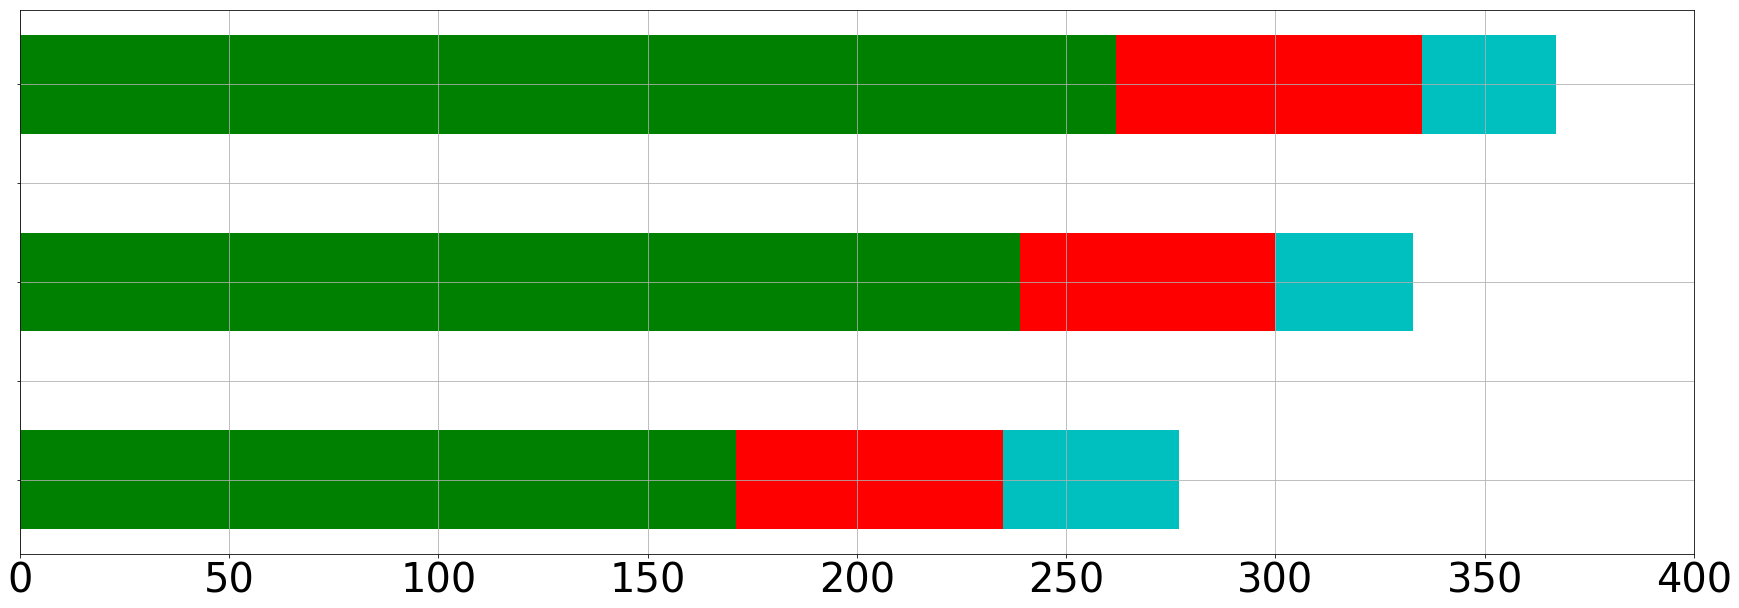

In [163]:
# data for analysis
# vgg resnet,m2det yolov2無しversion
external = np.array([262, 239, 171])[::-1]
boundary = np.array([73, 61, 64])[::-1]
others = np.array([32, 33, 42])[::-1]

plt.rcParams['font.size'] = 40
plt.figure(figsize=(30, 10))
plt.tick_params(
#                 labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

plt.xlim(0, 400)
plt.barh([0,1,2], external, color='green', align='center', height=0.5)
plt.barh([0,1,2], boundary, left=external, color='red', height=0.5)
plt.barh([0,1,2], others, left=external+boundary, color='c', height=0.5)
plt.grid()

plt.savefig('result_barh.png')

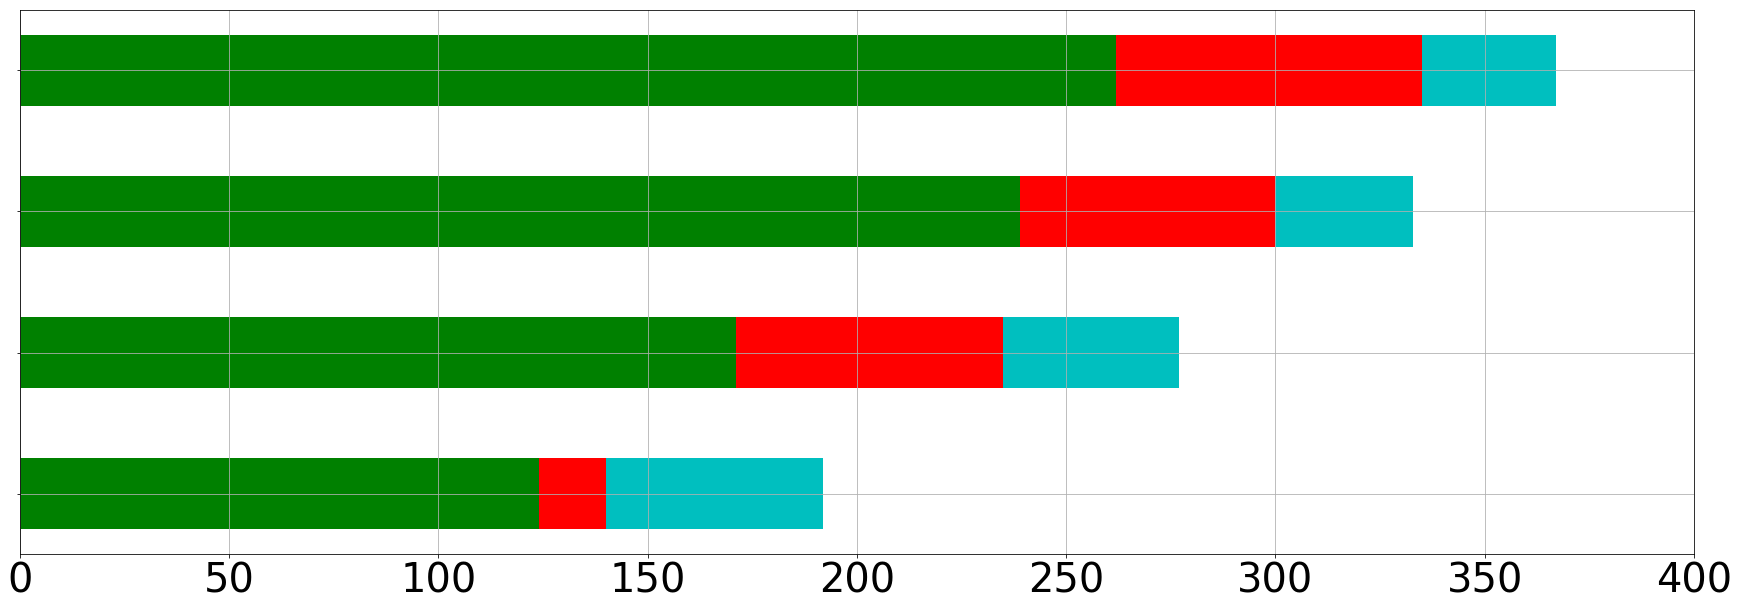

In [164]:
# data for analysis
# vgg resnet,m2det, yolov2
external = np.array([262, 239, 171, 124])[::-1]
boundary = np.array([73, 61, 64, 16])[::-1]
others = np.array([32, 33, 42, 52])[::-1]

plt.rcParams['font.size'] = 40
plt.figure(figsize=(30, 10))
plt.tick_params(
#                 labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

plt.xlim(0, 400)
plt.barh([0,1,2,3], external, color='green', align='center', height=0.5)
plt.barh([0,1,2,3], boundary, left=external, color='red', height=0.5)
plt.barh([0,1,2,3], others, left=external+boundary, color='c', height=0.5)
plt.grid()
# plt.savefig('result2_barh.png')

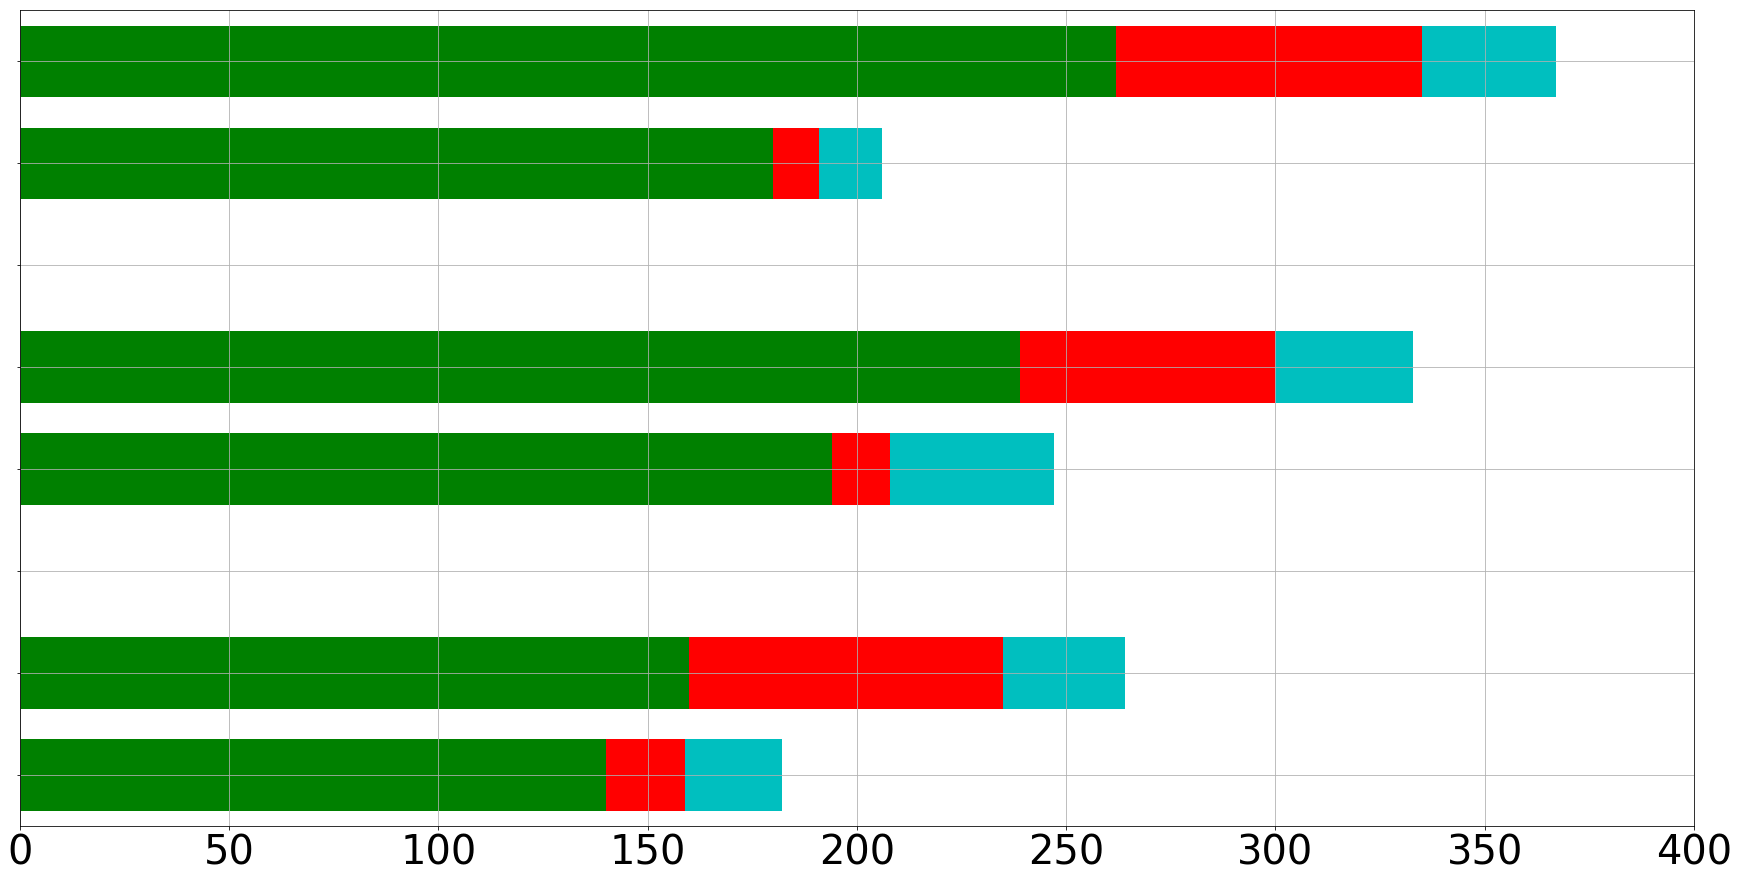

In [84]:
# data for analysis
# binary - soft (ssd, ssd, m2det)
external = np.array([262, 180, 239, 194, 160, 140])[::-1]
boundary = np.array([73, 11, 61, 14, 75, 19])[::-1]
others = np.array([32, 15, 33, 39, 29, 23])[::-1]

plt.rcParams['font.size'] = 40
plt.figure(figsize=(30, 15))
plt.tick_params(
#                 labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

plt.xlim(0, 400)
plt.ylim(-0.5, 7.5)
plt.barh([0, 1, 3, 4, 6, 7], external, color='green', align='center', height=0.7)
plt.barh([0, 1, 3, 4, 6, 7], boundary, left=external, color='red', height=0.7)
plt.barh([0, 1, 3, 4, 6, 7], others, left=external+boundary, color='c', height=0.7)
plt.grid()
plt.savefig('result2_barh.png')

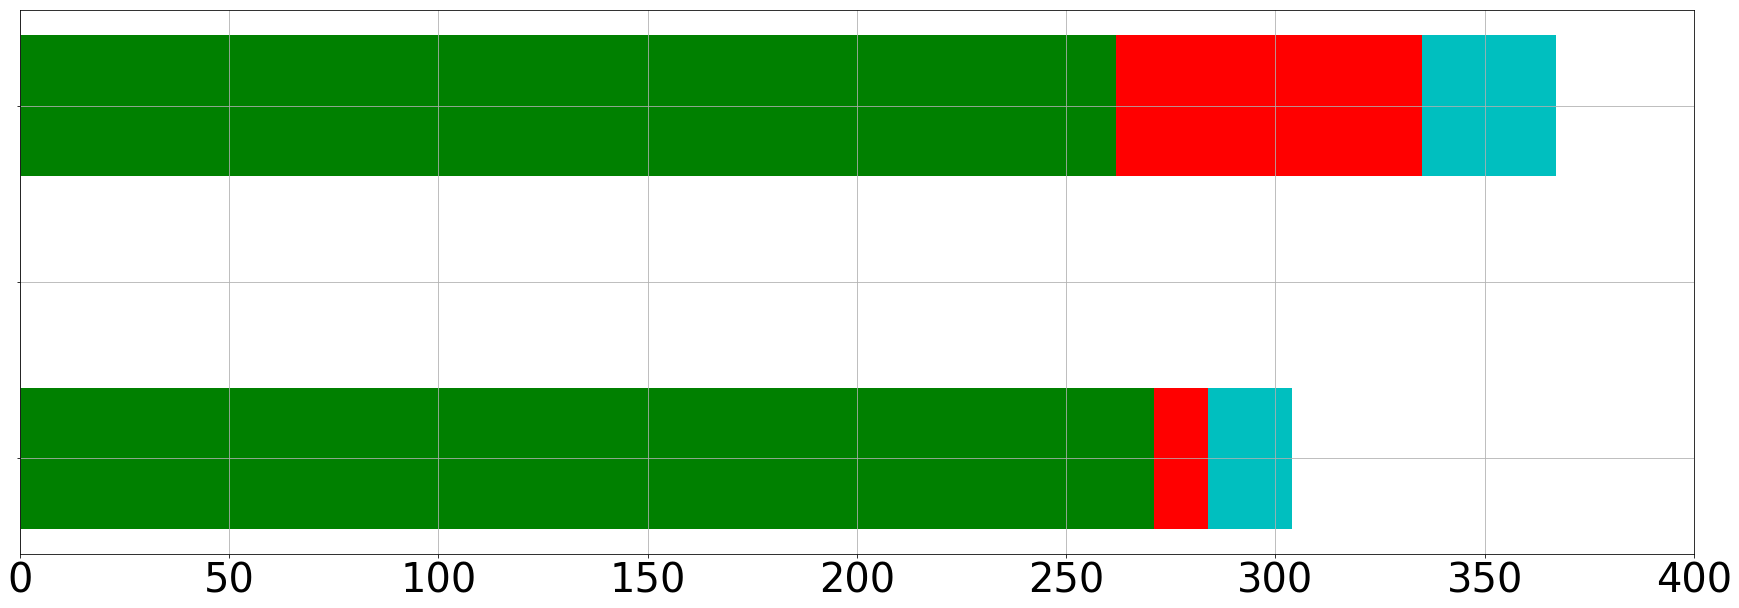

In [171]:
# data for analysis
# SSD-VGG16 (IOU05 vs IOU04)
external = np.array([262, 271])[::-1]
boundary = np.array([73, 13])[::-1]
others = np.array([32, 20])[::-1]

plt.rcParams['font.size'] = 40
plt.figure(figsize=(30, 10))
plt.tick_params(
#                 labelbottom=False,
                labelleft=False,
                labelright=False,
                labeltop=False)

plt.xlim(0, 400)
plt.barh([0,1], external, color='green', align='center', height=0.4)
plt.barh([0,1], boundary, left=external, color='red', height=0.4)
plt.barh([0,1], others, left=external+boundary, color='c', height=0.4)
plt.grid()

plt.savefig("IOU_05_04.png")